# Purpose of this simulation


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *
from weights_linear_regression import calc_R2_with_sim_C

# so that we write in latex
from matplotlib import rc
from afs_plotting import subplots_with_labels

rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')
sns.set_theme('paper', font = 'Arial')

save_to_gdrive = True # this is done through the gdrive's mapping to the local file system
gdrive_directory = '/home/aolab/gdrive/Projects/Feature Selection/Figures/'
dpi_value = 300

# ideas

In [33]:
# this is for creating exp_conditions that scan the difference across the files
#for comparision
#data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/more_neurons/run_3/'
# data_dump_folder = \
# 'D:/sim_data/gaussian_peaks/2022_02_02_gaussian_peaks/'

data_dump_folder = \
'/home/aolab/sijia/data/figure5_convex_encoder_change/'

ROUND_DECIMALS = 3


random_seed =2
n_neurons = 128

# clda setup 
rho = 0.5
batchlen = 100
feature_selection_method = "joint_convex"
encoder_change_mode = "shuffle_rows"
# encoder_change_mode = "change_to_zeros"

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3


# parameters for smoothe convex optimization
feature_selection_method = "joint_convex"
smoothness_array = np.arange(0.0, 0.15, 0.025) 
sparsity_array = [0.125]
decay_factor_array = [0.2]


smoothness_array =  np.arange(0.0, 0.15, 0.025)

smoothness_array = np.round(smoothness_array, ROUND_DECIMALS)

num_lags_array = [3]
num_of_features = 32 # specify how many features we want to use, or None


exp_conds = []
for sparsity_val in sparsity_array:
    for smoothness_val in smoothness_array:
        for num_lag in num_lags_array:
            for decay_factor in  decay_factor_array:

                    # no one can escape the beauty of python one-liner, granted at the expense of line width
                    sparsity_val, smoothness_val = np.round(sparsity_val, ROUND_DECIMALS), np.round(smoothness_val, ROUND_DECIMALS)
                    

                    exp_conds_wo = [f'{feature_selection_method}_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batchlen}_sparsity_{sparsity_val}_smooth_{smoothness_val}_lags_{num_lag}_decay_{decay_factor}_num_feats_{num_of_features}_{encoder_change_mode}' ]

                    exp_conds.extend(exp_conds_wo)


# feature_selection_schemes = ['Full set', 'Smooth convex selection', 'Lasso selection']
feature_selection_schemes = [ 'Smooth convex selection'] 

NUM_SPARSITY, NUM_SMOOTH = len(sparsity_array), len(smoothness_array)

print("the folder at which data is located:")
print(data_dump_folder)
print(f"we have {len(exp_conds)}" , f"num of sparsity vals {NUM_SPARSITY}", f'num of smoothness vals {NUM_SMOOTH}')
for e in exp_conds:print(e)

the folder at which data is located:
/home/aolab/sijia/data/figure5_convex_encoder_change/
we have 6 num of sparsity vals 1 num of smoothness vals 6
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.0_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.025_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.05_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.075_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.1_lags_3_decay_0.2_num_feats_32_shuffle_rows
joint_convex_1.0_2_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.125_smooth_0.125_lags_3_decay_0.2_num_feats_32_shuffle_rows


In [34]:
from afs_files import load_feature_selection_files, load_and_convert_clda_pickle_files
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
clda_data_all = load_and_convert_clda_pickle_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 6 number of experiments


# Check feature selection strategies

## check feature weights 

In [35]:
feature_weights = exp_data_all[0]['feature_selection']['feature_weights']
exp_data_all[0]['feature_selection'].keys()
new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_C = exp_data_all[0]['feature_selection']['sim_C']

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

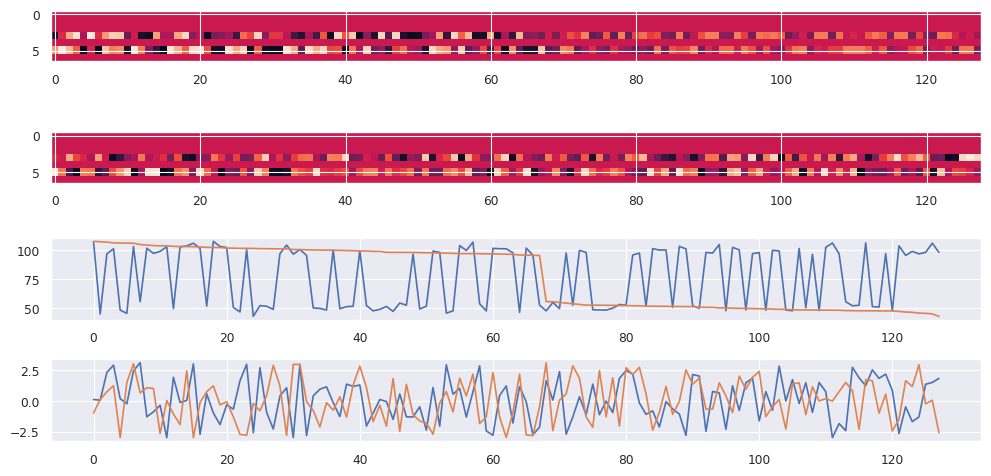

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(10, 5))
ax[0].imshow(sim_C.T)
old_tuning = np.linalg.norm(sim_C, axis=1)
ax[1].imshow(new_sim_c.T)

new_tuning = np.linalg.norm(new_sim_c, axis=1)
ax[2].plot(new_tuning)
ax[2].plot(old_tuning)

ax[3].plot((np.arctan2(new_sim_c[:, 3], new_sim_c[:, 5])))
ax[3].plot((np.arctan2(sim_C[:, 3], sim_C[:, 5])))

fig.tight_layout()


Text(0.5, 1.0, 'Feature distribution std 3 Hz')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

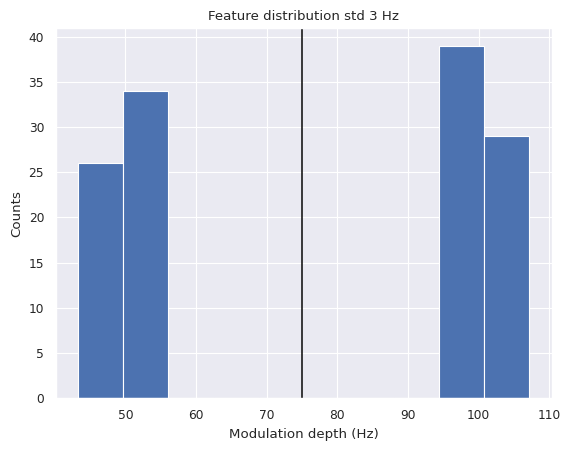

In [37]:
# plot the histogram of the feature weights

std = std_of_peaks

fig_weight, ax_weight = plt.subplots()
ax_weight.hist(feature_weights)
ax_weight.axvline(x = 75, color = 'k')
ax_weight.set_xlabel('Modulation depth (Hz)')
ax_weight.set_ylabel('Counts')
ax_weight.set_title(f'Feature distribution std {std} Hz')

## check between conditions

In [38]:
# calculate encoding truth
from afs_plotting import calculate_encoder_weight_change

new_sim_c = exp_data_all[2]['feature_selection']['new_sim_c']
sim_c = exp_data_all[2]['feature_selection']['sim_C']
encoder_weight_change_shuffle = calculate_encoder_weight_change(sim_c, new_sim_c=new_sim_c,
                                        include_new_sim_c=True, nnum_of_repeats_before=30, num_of_repeats_after=30)

## feature batches

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

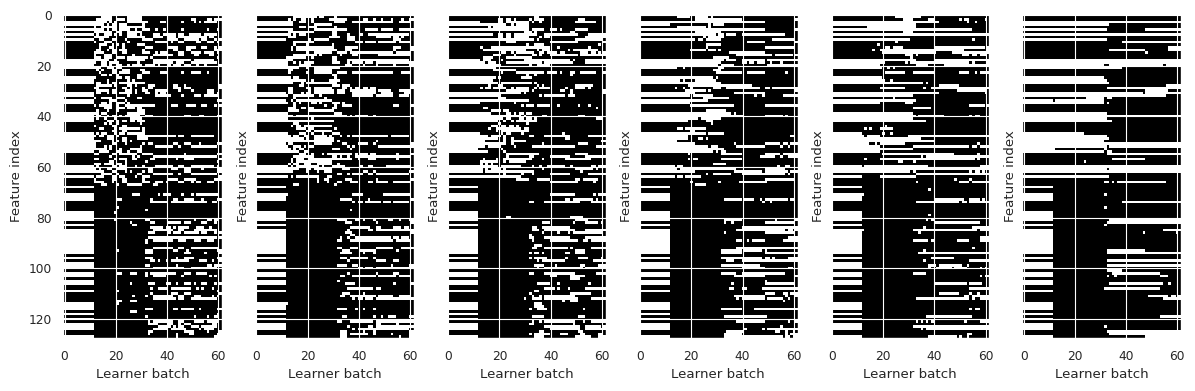

In [39]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(1, num_columns, 
                                                    sharey = True,
                                                    figsize = (12, 4))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity)):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        #only title the exp if there are three exp, right. 
        #a.set_title(np.round(s, decimals = ROUND_DECIMALS))

    fig_feat_activity.tight_layout()


In [40]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)

In [41]:
print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, mode = "incremental")

print(smoothness_conds_by_batch.shape)

(6, 62, 128)
(6, 61)


/tmp/ipykernel_3575652/572579485.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sparsity_array)


Text(0.5, 1.0, '')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

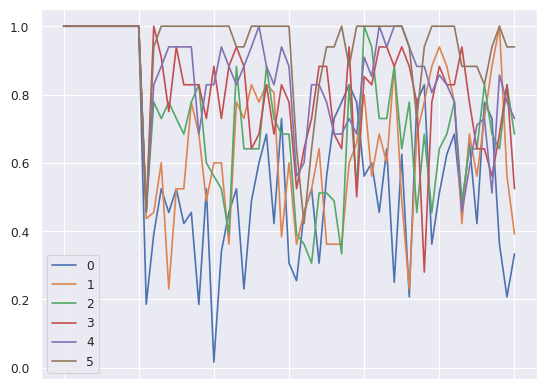

In [42]:
#sns.set_palette("Blues")

ax  = sns.lineplot(data = smoothness_conds_by_batch.T, dashes=False)
ax.set_xticklabels(sparsity_array)
ax.set_title("")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

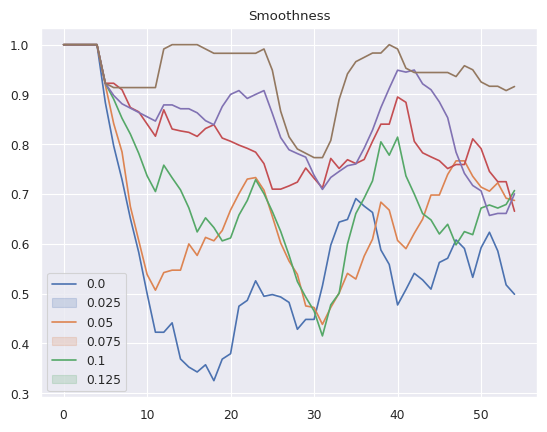

In [43]:

# Assuming smoothness_conds_by_batch is a numpy array with shape (n_batches, n_features)
window_size = 7
weights = np.ones(window_size) / window_size
smoothness_conds_by_batch_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=1,
                                                   arr=smoothness_conds_by_batch)

ax  = sns.lineplot(data = smoothness_conds_by_batch_ma.T, dashes=False)
# ax.set_xticklabels(sparsity_array)
ax.set_title("Smoothness")
ax.legend(smoothness_array, loc = 'best')


## calculate the relevance

In [44]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    # intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    # spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    try:
        intended_kin = clda_data_all[exp_index]['intended_kin']
        spike_counts_batch = clda_data_all[exp_index]['spike_counts_batch']

        intended_kin = np.array(intended_kin)
        print(intended_kin.shape)

        intended_velocities = intended_kin[:, [X_VEL_STATE, Y_VEL_STATE, CONST_STATE],:]
        # # get C_mat
        feature_selection_data = exp_data_all[exp_index]['feature_selection']
        C_mat = feature_selection_data["C_mat"]
        feat_set = feature_selection_data["feat_set"]

        # # calculate R_2 over batches
        R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, 
                                            intended_velocities,
                                            C_mat, feat_set, debug = False)
        
        # #save  the results
        R_2_over_batches_all_exp.append(R_2_over_batches)
        
        
    except Exception as e:
        print(f"KeyError: {e}not found in data.")
    
    # #save  the results
    # R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

(60, 7, 100)
0
(60, 7, 100)
1
(60, 7, 100)
2
(60, 7, 100)
3
(60, 7, 100)
4
(60, 7, 100)
5


In [45]:
# apply moving average to the first axis
window_size = 6
weights = np.ones(window_size) / window_size
R_2_over_batches_all_exp_gap_ma = np.apply_along_axis(lambda x: np.convolve(x, weights, mode='valid'), 
                                                   axis=0,
                                                   arr=R_2_over_batches_all_exp_gap)


# Behaviour comparision

## count how many rewards

In [46]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 
reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

Text(0, 0.5, 'Reward rate (rewards/min)')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

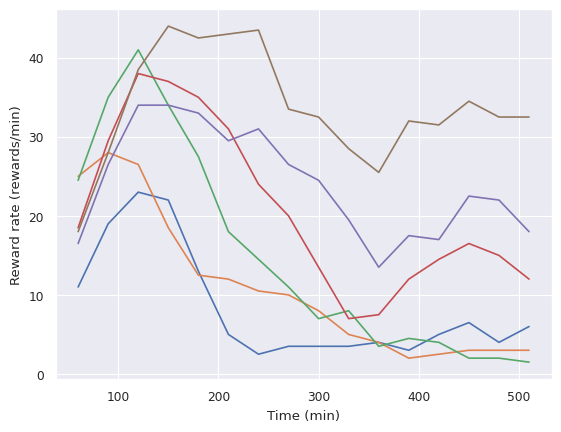

In [47]:
colors = ['blue', 'orange', 'red']

plt.plot(window_time_stamps, reward_rate_all.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')


# Include the results from the stationary encoder

In [48]:
ROUND_DECIMALS = 3


data_dump_folder = \
'/home/aolab/sijia/data/figure4_convex_stationary_encoder/'
random_seed = 0
n_neurons = 128
# 
mean_first_peak = 50
mean_second_peak = 100
std = 3
ENCODER_CHANGE_MODE = "same"

# clda setup 
rho = 0.5
batchlen = 100

# noises = np.arange(9)
# noises = np.exp2(noises)
noises = [32]
noise = 32

smoothness_coef = 0.1
num_of_lags = 3#  this is the K in the formulation, the number of batch updated feature scores we expect it to be.
past_batch_decay_factor = 0.2


exp_conds = []

sparsity_array = [0.06]
smoothness_array = [0.0, 0.125]

sparsity_array = np.round(sparsity_array, ROUND_DECIMALS)
smoothness_array = np.round(smoothness_array, ROUND_DECIMALS)

num_of_features_array  = [32]   # specify how many features we want to use, or None
#TODO: add 32 to that number of features array

for sparsity_val in sparsity_array:
    for smoothness_val in smoothness_array:
        for num_of_features in num_of_features_array:
            exp_conds_add = [f'joint_convex_{1.0}_{random_seed}_noise_{noise}_{n_neurons}_{mean_second_peak}_{std}_clda_rho_{rho}_batchlen_{batchlen}_sparsity_{sparsity_val}_smooth_{smoothness_val}_lags_{num_of_lags}_decay_{past_batch_decay_factor}_num_feats_{num_of_features}_{ENCODER_CHANGE_MODE}' ]
            exp_conds.extend(exp_conds_add)
        #exp_conds.extend(exp_conds_keep)

NUM_SPARSITY, NUM_SMOOTH = len(sparsity_array), len(smoothness_array)

print("the folder at which data is located:")
print(data_dump_folder)
print(f"we have {len(exp_conds)}" , f"num of sparsity vals {NUM_SPARSITY}", f'num of smoothness vals {NUM_SMOOTH}')


for e in exp_conds: print(e)

the folder at which data is located:
/home/aolab/sijia/data/figure4_convex_stationary_encoder/
we have 2 num of sparsity vals 1 num of smoothness vals 2
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.06_smooth_0.0_lags_3_decay_0.2_num_feats_32_same
joint_convex_1.0_0_noise_32_128_100_3_clda_rho_0.5_batchlen_100_sparsity_0.06_smooth_0.125_lags_3_decay_0.2_num_feats_32_same


In [49]:
(exp_data_all_stationary, exp_metadata_all_stationary) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 6 number of experiments


## calculate the encoder change

In [60]:
new_sim_c = exp_data_all_stationary[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all_stationary[0]['feature_selection']['sim_C']
encoder_weight_change_stationary = calculate_encoder_weight_change(sim_c, new_sim_c=new_sim_c,
                                        include_new_sim_c=True, nnum_of_repeats_before=30, num_of_repeats_after=30)

## make a summary figure

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

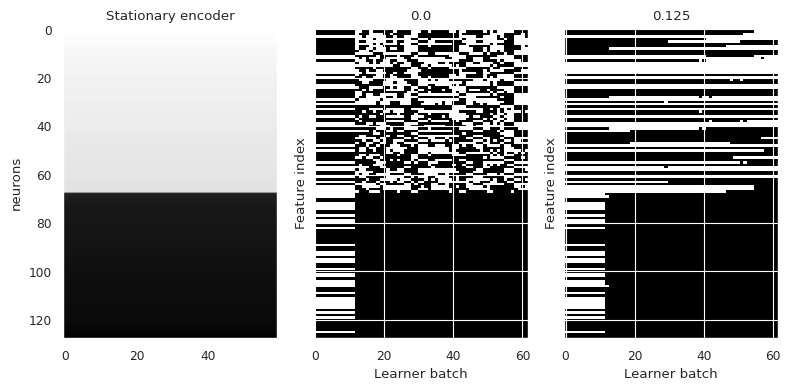

In [61]:
num_columns = len(exp_data_all_stationary) + 1

fig_feat_activity, ax_feat_activity = plt.subplots(1,num_columns, 
                                                   sharey = True,
                                                   figsize = (8, 4))

# the first figure is the stationary encoder
# then the shuffling encoder case
ax_feat_activity[0].imshow(encoder_weight_change_stationary, cmap = 'gray',
                                          aspect = 'auto')
ax_feat_activity[0].grid(False)
ax_feat_activity[0].set_ylabel('neurons')
ax_feat_activity[0].set_title('Stationary encoder')


for i, (e, a, s) in enumerate(zip(exp_data_all_stationary,  
                                ax_feat_activity[1:], smoothness_array)):
    plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
    
    #only title the exp if there are three exp, right. 
    a.set_title(np.round(s, decimals = ROUND_DECIMALS))

fig_feat_activity.tight_layout()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

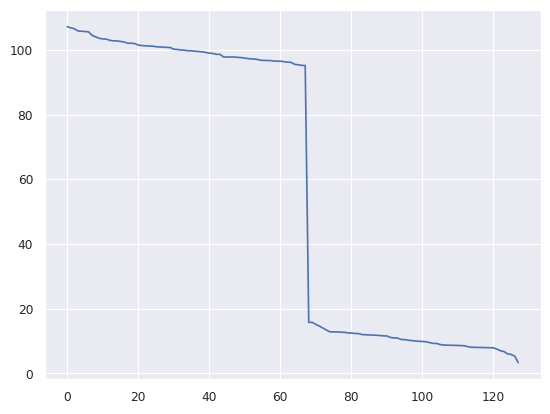

In [57]:
plt.plot(encoder_weight_change_stationary[:,59])

# Make a summary figure

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

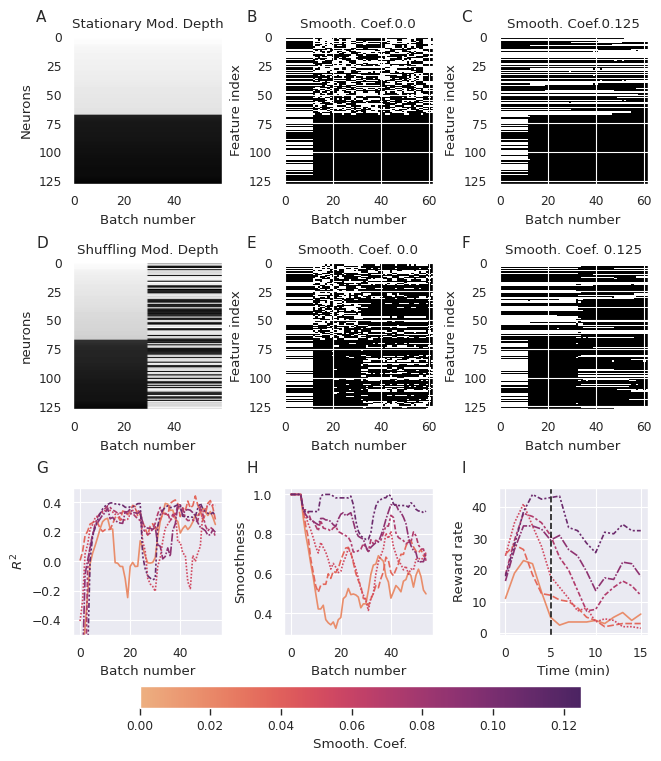

In [72]:
encoder_shuffling_time = 5
num_rows = 3 # three rows, one row for stationary encoder, 2 rows for shuffling encoder.
num_cols = 3 # three columns, one column for each smoothness coefficient, sort of 

# let's make a summary plot
summary_figure, summary_axes_stationary_shuffling = subplots_with_labels(3, 3, figsize = (6.5, 7.5))

# the first row is the stationary encoder
ax_feat_activity = summary_axes_stationary_shuffling[0,:]

ax_feat_activity[0].imshow(encoder_weight_change_stationary, cmap = 'gray',
                                          aspect = 'auto')
ax_feat_activity[0].grid(False)
ax_feat_activity[0].set_ylabel('Neurons')
ax_feat_activity[0].set_title('Stationary Mod. Depth')
ax_feat_activity[0].set_xlabel('Batch number')


for i, (e, a, s) in enumerate(zip(exp_data_all_stationary,  
                                ax_feat_activity[1:], smoothness_array)):
    plot_feature_selection(e['feature_selection']['feat_set'], 
                            ax = a)
    
    #only title the exp if there are three exp, right. 
    a.set_title(f'Smooth. Coef.{np.round(s, decimals = ROUND_DECIMALS)}')
    a.set_xlabel('Batch number')




# the next two rows, we quantify the shuffling encoder case
summary_axes = summary_axes_stationary_shuffling[1:,:]


# then the shuffling encoder case
summary_axes[0,0].imshow(encoder_weight_change_shuffle, cmap = 'gray',
                                          aspect = 'auto')
summary_axes[0,0].grid(False)
summary_axes[0,0].set_ylabel('neurons')
summary_axes[0,0].set_title('Shuffling Mod. Depth')
summary_axes[0,0].set_xlabel('Batch number')

# plot the feature selection results
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = summary_axes[0,1])
plot_feature_selection(exp_data_all[-1]['feature_selection']['feat_set'], ax = summary_axes[0,2])
summary_axes[0,1].set_title(f'Smooth. Coef. {smoothness_array[0]}')
summary_axes[0,2].set_title(f'Smooth. Coef. {smoothness_array[-1]}')
summary_axes[0,1].set_xlabel('Batch number')
summary_axes[0,2].set_xlabel('Batch number')



import seaborn as sns
import matplotlib.pyplot as plt

# define the colors for each row
# plot the smoothness of the features
colors = sns.color_palette('flare', n_colors=len(exp_data_all))
norm = plt.Normalize(smoothness_array.min(), smoothness_array.max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)

# # plot the number of features selected
# sns.lineplot(data=num_features_exp_by_batch.T, palette=colors, ax=summary_axes[0,1], legend=False)
# summary_axes[0,1].set_xlabel('Batch number')
# summary_axes[0,1].set_ylabel('Number of features')
# summary_axes[0,1].set_title('Number of features selected')

# plot the relevance of the features
sns.lineplot(data=R_2_over_batches_all_exp_gap_ma, palette=colors, ax=summary_axes[1,0], legend=False)
summary_axes[1,0].set_xlabel('Batch number')
summary_axes[1,0].set_ylabel(r'$R^2$')
summary_axes[1,0].set_ylim([-0.5, 0.5])

# plot the smoothness of the features
sns.lineplot(data=smoothness_conds_by_batch_ma.T, palette=colors, ax=summary_axes[1,1], legend=False)
summary_axes[1,1].set_xlabel('Batch number')
summary_axes[1,1].set_ylabel('Smoothness')

# plot the reward rate
sns.lineplot(data=reward_rate_all.T, palette=colors, ax=summary_axes[1,2], legend=False)
summary_axes[1,2].set_ylabel('Reward rate')
summary_axes[1,2].set_xlabel('Time (min)')
# add a vertical line that shows encoder shuffline
summary_axes[1,2].axvline(x=encoder_shuffling_time, color='k', linestyle='--')



cbar = summary_figure.colorbar(sm, ax=summary_axes[1,:],
                 orientation='horizontal',
                 location = "bottom")
cbar.set_label('Smooth. Coef.')




### gdrive

In [73]:
if save_to_gdrive:
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.pdf', dpi=dpi_value)
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.png', dpi=dpi_value)
    summary_figure.savefig(gdrive_directory + 'figure5_smooth_encoder_change.svg', dpi=dpi_value)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f